<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/3_First_order_methods/3_11_Minibatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 3: First order methods

# Mini-Batch Optimization

In machine learning applications we almost never tasked with minimizing a single mathematical function, but one that consist a *sum* of $P$ functions.  In other words the sort of function $g$ we very often need to minimize in machine learning applications takes the general form 

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p\left(\mathbf{w}\right).
\end{equation}

where $g_1,\,g_2,\,...,g_P$ are mathematical functions themselves.  In machine learning applications hese functions $g_1,\,g_2,\,...,g_P$ are almost always of the same type - e.g., they can be convex quadratic functions with different constants paramterized by the same weights $\mathbf{w}$.  

This special *summation structure* allows for a simple but very effective enhancement to virtually any local optimization scheme, and is called *mini-batch optimization*.  Mini-batch optimization is most often used in combination with a gradient-based step like any of those discussed in the prior Sections, which is why we discuss the subject in this Chapter.

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_3_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_library
    else:
        print('chapter_3_library already cloned!')

    # clone images
    if not Path('chapter_3_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_images
    else:
        print('chapter_3_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_3_library')
sys.path.append('./chapter_3_images') 

# import section helper
import section_3_11_helpers

# image paths
image_path_1 = 'chapter_3_images/batch_vs_miinbatch_functions.png'
image_path_2 = 'chapter_3_images/minibatch_functions.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## A simple idea with powerful consequences

Suppose we were to apply a local optimization scheme to minimize a function $g$ of the form

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p\left(\mathbf{w}\right).
\end{equation}


where $g_1\,g_2,\,...,g_P$ are all functions of the same kind (e.g., quadratics with different constants parameterized by $\mathbf{w}$).  

The motivation for *mini-batch optimization* rests on a simple inquiry: for this sort of function $g$, what would happen if instead of taking one descent step in $g$ - that is, one descent step in the entire sum of the functions $g_1,\,g_2,\,...,g_P$ *simultaneously* - we took a sequence of $P$ descent steps in $g_1,\,g_2,\,...,g_P$ *sequentially* by first descending in $g_1$, then in $g_2$, etc., until finally we descend in $g_P$.  In other words, what would happen if we were to try to minimize $g$ by taking descent steps in the summand functions $g_1,\,g_2,\,...,g_P$ one-at-a-time?   As we will see empircaly throughout this text, starting with the examples below, in many instances this idea can actually lead to considerably faster optimization of a function $g$ consisting of a sum of $P$ functions as detailed in general above above.

 The gist of this idea is drawn graphically in the figure below for the case $P = 3$, where we compare the idea of taking a the a descent step simultaneously in $g_1,\,g_2,\,...,g_P$ versus a sequence of $P$ descent steps in $g_1$ then $g_2$ etc., up to $g_P$. 

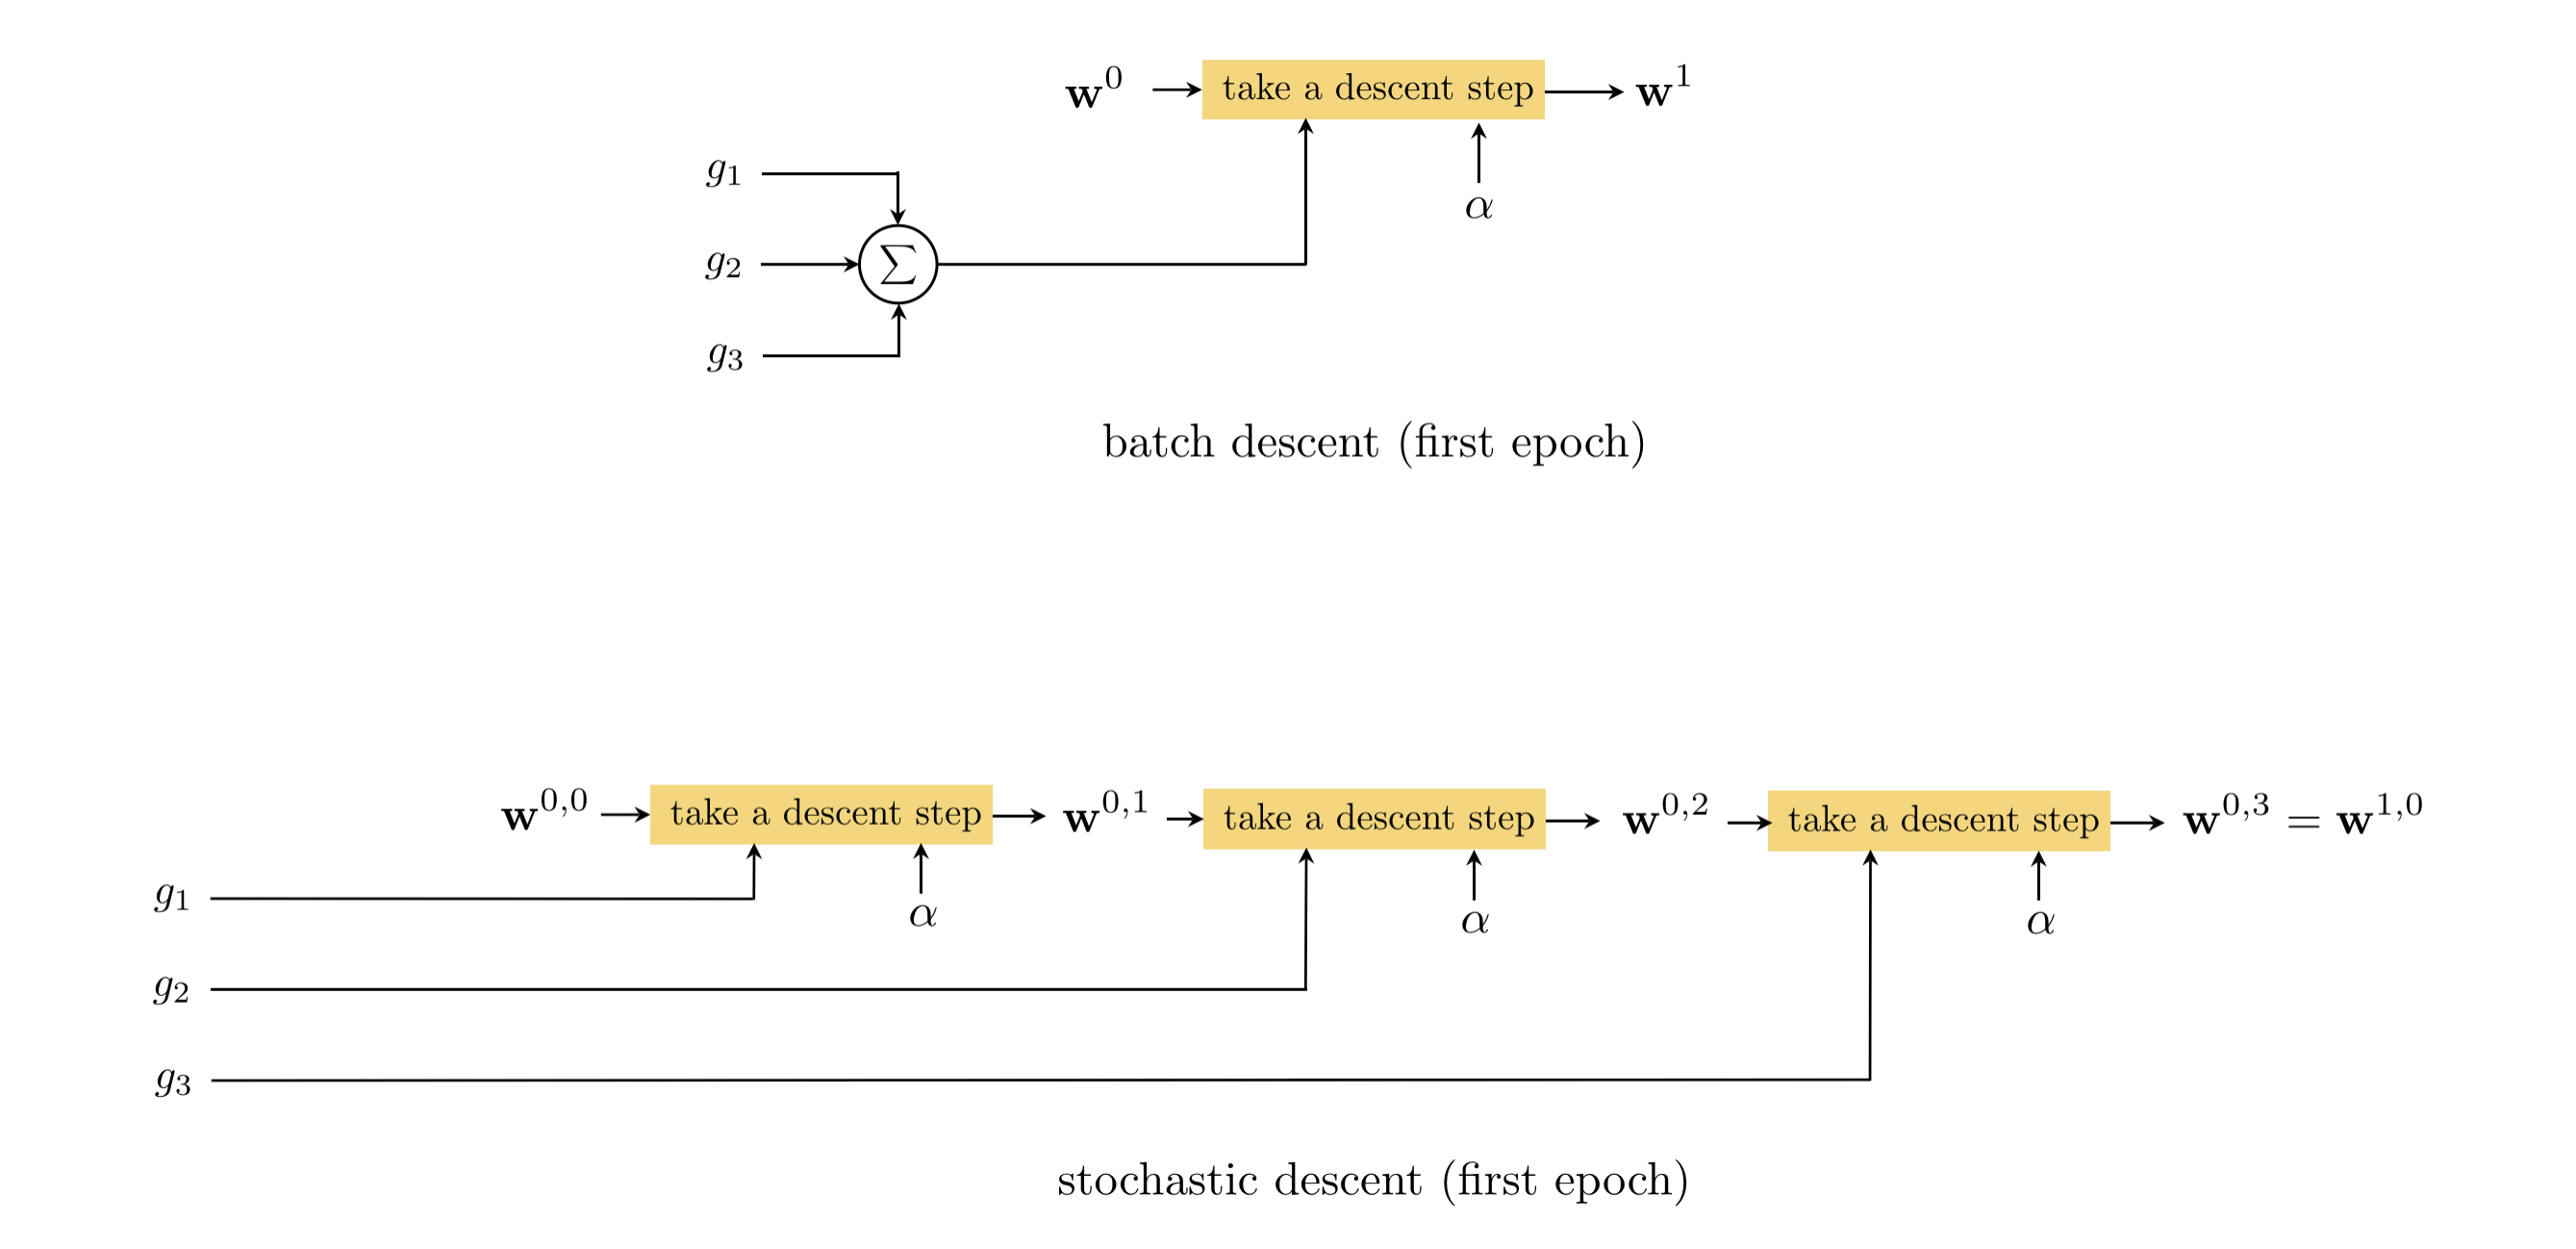

In [3]:
Image(image_path_1, width=1000)

Taking the first step of a local method, we begin at some initial point $\mathbf{w}^0$, determine a descent direction $\mathbf{d}^0$, and transition to a new point $\mathbf{w}^1$ as 

\begin{equation}
\mathbf{w}^1 = \mathbf{w}^0 + \alpha \, \mathbf{d}^0.
\end{equation}

By analogy, if we were to follow the mini-batch idea detailed above this entails taking a sequence of $P$ steps, which we now describe.  If we call our initial point $\mathbf{w}^{0,0} = \mathbf{w}^0$, we then first determine a descent direction $\mathbf{d}^{0,1}$ in $g_1$, the first function in the sum of $g$, and take a step in this direction as

\begin{equation}
\mathbf{w}^{0,1} = \mathbf{w}^{0,0} + \alpha \, \mathbf{d}^{0,1}.
\end{equation}

Next we determine a descent direction $\mathbf{d}^{0,2}$ in $g_2$, the second function in the sum for $g$, and take a step in this direction

\begin{equation}
\mathbf{w}^{0,2} = \mathbf{w}^{0,1} + \alpha \, \mathbf{d}^{0,2}.
\end{equation}

Continuing this pattern we take a sequence of $P$ steps, where $\mathbf{d}^{0,p}$ is the descent direction found in $g_p$, that takes the following form

\begin{array}
\mathbf{w}^{0,1} = \mathbf{w}^{0,0} + \alpha \, \mathbf{d}^{0,1} \\
\mathbf{w}^{0,2} = \mathbf{w}^{0,1} + \alpha \, \mathbf{d}^{0,2} \\
\,\,   \,\,\,\,\,\,   \,\,\,\,\,\,     \,\,\,\,\,\,   \vdots \\
\mathbf{w}^{0,p} = \mathbf{w}^{0,p-1} + \alpha \, \mathbf{d}^{0,p} \\
\,\,   \,\,\,\,\,\,   \,\,\,\,\,\,     \,\,\,\,\,\,   \vdots \\
\mathbf{w}^{0,P} = \mathbf{w}^{0,P-1} + \alpha \, \mathbf{d}^{0,P} \\
\end{array}

This sequence of steps completes one sweep through the functions $g_1,\,g_2,\,...,g_P$, and is commonly referred to as an *epoch*. If we continued this pattern and took another sweep through each the $P$ functions we perform a second *epoch* of steps, and so on.  Below we compare the $k^{th}$ step of a standard descent method (left) to the $k^{th}$ *epoch* of this mini-batch idea (right).  


\begin{array} {r|r} 
\text{full (batch) descent step}  & \text{mini-batch epoch, batch-size = 1} \\
\hline
  &  \mathbf{w}^{k,1} = \mathbf{w}^{k-1,0} + \alpha \, \mathbf{d}^{k-1,1}   \\
  &     \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
\mathbf{w}^{k} = \mathbf{w}^{k-1} + \alpha \, \mathbf{d}^{k-1}   &  \mathbf{w}^{k,p} = \mathbf{w}^{k-1,p-1} + \alpha \, \mathbf{d}^{k-1,p} \\
  &       \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
  &  \mathbf{w}^{k,P} = \mathbf{w}^{k-1,P-1} + \alpha \, \mathbf{d}^{k-1,P} \\
\end{array}

When employed with gradient-based steps these steps take a very convinent form.  For example, noting that $\nabla g\left(\mathbf{w}\right) = \nabla \sum_{p=1}^P g_p\left(\mathbf{w}\right)$ the $k^{th}$ standard gradient descent step in all $P$ summands can be written as

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \nabla \,\sum_{p=1}^P g_p\left(\mathbf{w}^{k-1}\right)
\end{equation}

where here the descent direction $\mathbf{d}^{k-1} = - \nabla \,\sum_{p=1}^P g_p\left(\mathbf{w}^{k-1}\right)$.  The gradient descent direction in just a single function $g_p$ at the $k^{th}$ epoch of a mini-batch run is likewise just *negative gradient of this function alone* $ \mathbf{d}^{k-1,p} = - \nabla  g_p\left(\mathbf{w}^{k-1,p}\right)$, and so the step minibatch step $\mathbf{w}^{k,p} = \mathbf{w}^{k-1,p-1} + \alpha \, \mathbf{d}^{k-1,p}$ is given by

\begin{equation}
\mathbf{w}^{k,p} = \mathbf{w}^{k-1,p-1} - \alpha \,\nabla g_p\left(\mathbf{w}^{k-1,p}\right).
\end{equation}

The table above comparing a single descent step at the $k^{th}$ epoch of standard gradient descent to its analagous mini-batch epoch can then be written as follows below.


\begin{array} {r|r} 
\text{full (batch) descent step}  & \text{mini-batch epoch, batch-size = 1} \\
\hline
  &  \mathbf{w}^{k,1} = \mathbf{w}^{k-1,0} - \alpha \,\nabla g_1\left(\mathbf{w}^{k-1,1}\right)   \\
  &     \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \,\nabla\sum_{p=1}^P  g_p\left(\mathbf{w}^{k-1}\right)  &  \mathbf{w}^{k,p} = \mathbf{w}^{k-1,p-1} - \alpha \,\nabla g_p\left(\mathbf{w}^{k-1,p}\right) \\
  &       \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
  &  \mathbf{w}^{k,P} = \mathbf{w}^{k-1,P-1} - \alpha \,\nabla g_P\left(\mathbf{w}^{k-1,P}\right)  \\
\end{array}

##   Descending with larger mini-batch sizes

Instead of taking $P$ sequential steps in single functions $g_p$ (a mini-batch of *size $1$*) one-at-a-time, we can more general (with functions $g$ that take the form $g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p\left(\mathbf{w}\right)$) take fewer steps in one epoch, but take each step with respect to *several* of the functions $g_p$ e.g., two functions at-a-time, or three functions at-a-time, etc.,.  With this slight twist on the idea detailed above we take fewer steps per epoch but take each with respect to larger non-overlapping subsets of the functions $g_1,\,g_2,\,...,g_P$, but still sweep through each function exactly once per epoch. 

Choosing a general batch size we split up our listing of functions into $M$ subsets, where each subset has the same size with perhaps the exception of one (e.g., if $P = 5$ and we choose a batch size of $2$ then we will have two subsets of two functions with a final subset containing just one).  If we denote $\Omega_{m}$ the set of indices of those summand functions $g_1,\,g_2,\,...,g_P$ in our $m^{th}$ mini-batch then during our $k^{th}$ epoch we take steps like those shown in the table below.  Here $\mathbf{d}^{k-1,m}$ is the descent direction computed for the $m^{th}$ minibatch.



\begin{array} {r|r} 
\text{full (batch) descent step}  & \text{mini-batch epoch, batch-size = M} \\
\hline
  &  \mathbf{w}^{k,1} = \mathbf{w}^{k-1,0} + \alpha \, \mathbf{d}^{k-1,1}   \\
  &     \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
\mathbf{w}^{k} = \mathbf{w}^{k-1} + \alpha \, \mathbf{d}^{k-1}   &  \mathbf{w}^{k,m} = \mathbf{w}^{k-1,m-1} + \alpha \, \mathbf{d}^{k-1,m} \\
  &       \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \\
  &  \mathbf{w}^{k,M} = \mathbf{w}^{k-1,M-1} + \alpha \, \mathbf{d}^{k-1,M} \\
\end{array}


The size of the subset used is called the *batch-size* of the proces e.g., in our description of the mini-batch optimization scheme above we used batch-size = $1$ (mini-batch optimization using a batch-size of $1$ is also often referred to as *stochastic optimization*).  What batch-size works best in practice - in terms of providing the greatest speed up in optimization - varies and is often problem dependent.

Once again in the case of gradient-based methods a mini-batch step using a batch size greater than $1$ can be written out quite clearly, and just as easily implemented.  If we denote by $\Omega_m$ the set of indices of our summand functions $g_1,\,g_2,\,...,g_P$ in the $m^{th}$ mini-batch , then during the $k^{th}$ epoch of our mini-batch optimization if we use the standard gradient method our descent direction is simply the negative gradient direction in the sum of these functions i.e., 

\begin{equation}
\mathbf{d}^{k-1,m} = - \nabla \,\sum_{p \in \Omega_m} g_p\left(\mathbf{w}^{k-1,m}\right).
\end{equation}

Our corresponding epoch of mini-batch steps with batch size $M$ looks as follows.


\begin{array} {r|r} 
\text{full (batch) descent step}  & \text{mini-batch epoch, batch-size = M} \\
\hline
  &  \mathbf{w}^{k,1} = \mathbf{w}^{k-1,0} - \alpha \nabla \,\sum_{p \in \Omega_1} g_p\left(\mathbf{w}^{k-1,1}\right)   \\
  &     \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,   \,\,\,\,\,\,   \,\,\,\,\,\,   \\
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \,\nabla\sum_{p=1}^P g_p\left(\mathbf{w}^{k-1}\right)  &  \mathbf{w}^{k,m} = \mathbf{w}^{k-1,m-1} - \alpha \nabla \,\sum_{p \in \Omega_m} g_p\left(\mathbf{w}^{k-1,m}\right) \\
  &       \vdots   \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,     \,\,\,\,\,\,  \,\,\,\,\,\,   \,\,\,\,\,\,   \\
  &  \mathbf{w}^{k,M} = \mathbf{w}^{k-1,M-1} - \alpha \nabla \,\sum_{p \in \Omega_M} g_p\left(\mathbf{w}^{k-1,M}\right)   \\
\end{array}

## Mini-batch optimization general performance

Is the trade-off - taking more steps per epoch with a mini-batch approach as opposed a full descent step - worth the extra effort?  Typically *yes*.  Often in practice when minimizing machine learning functions an epoch of mini-batch steps like those detailed above will drastically outperform an analagous full descent step - often referred to as a *full batch* or simply a *batch* epoch in the context of mini-batch optimiztaion.  
A prototypical comparison of a cost function history employing a batch and corresponding epochs of mini-batch optimization applied to the same hypothetical function $g$ with the same initialization $\mathbf{w}^0$ is shown in the figure below.  Because we take far more steps with the mini-batch approach and because each $g_p$ takes the same form, each epoch of the mini-batch approach typically outperforms its full batch analog.  Even when taking into account that far more descent steps are taken during an epoch of mini-batch optimization the method often greatly outperforms its full batch analog.

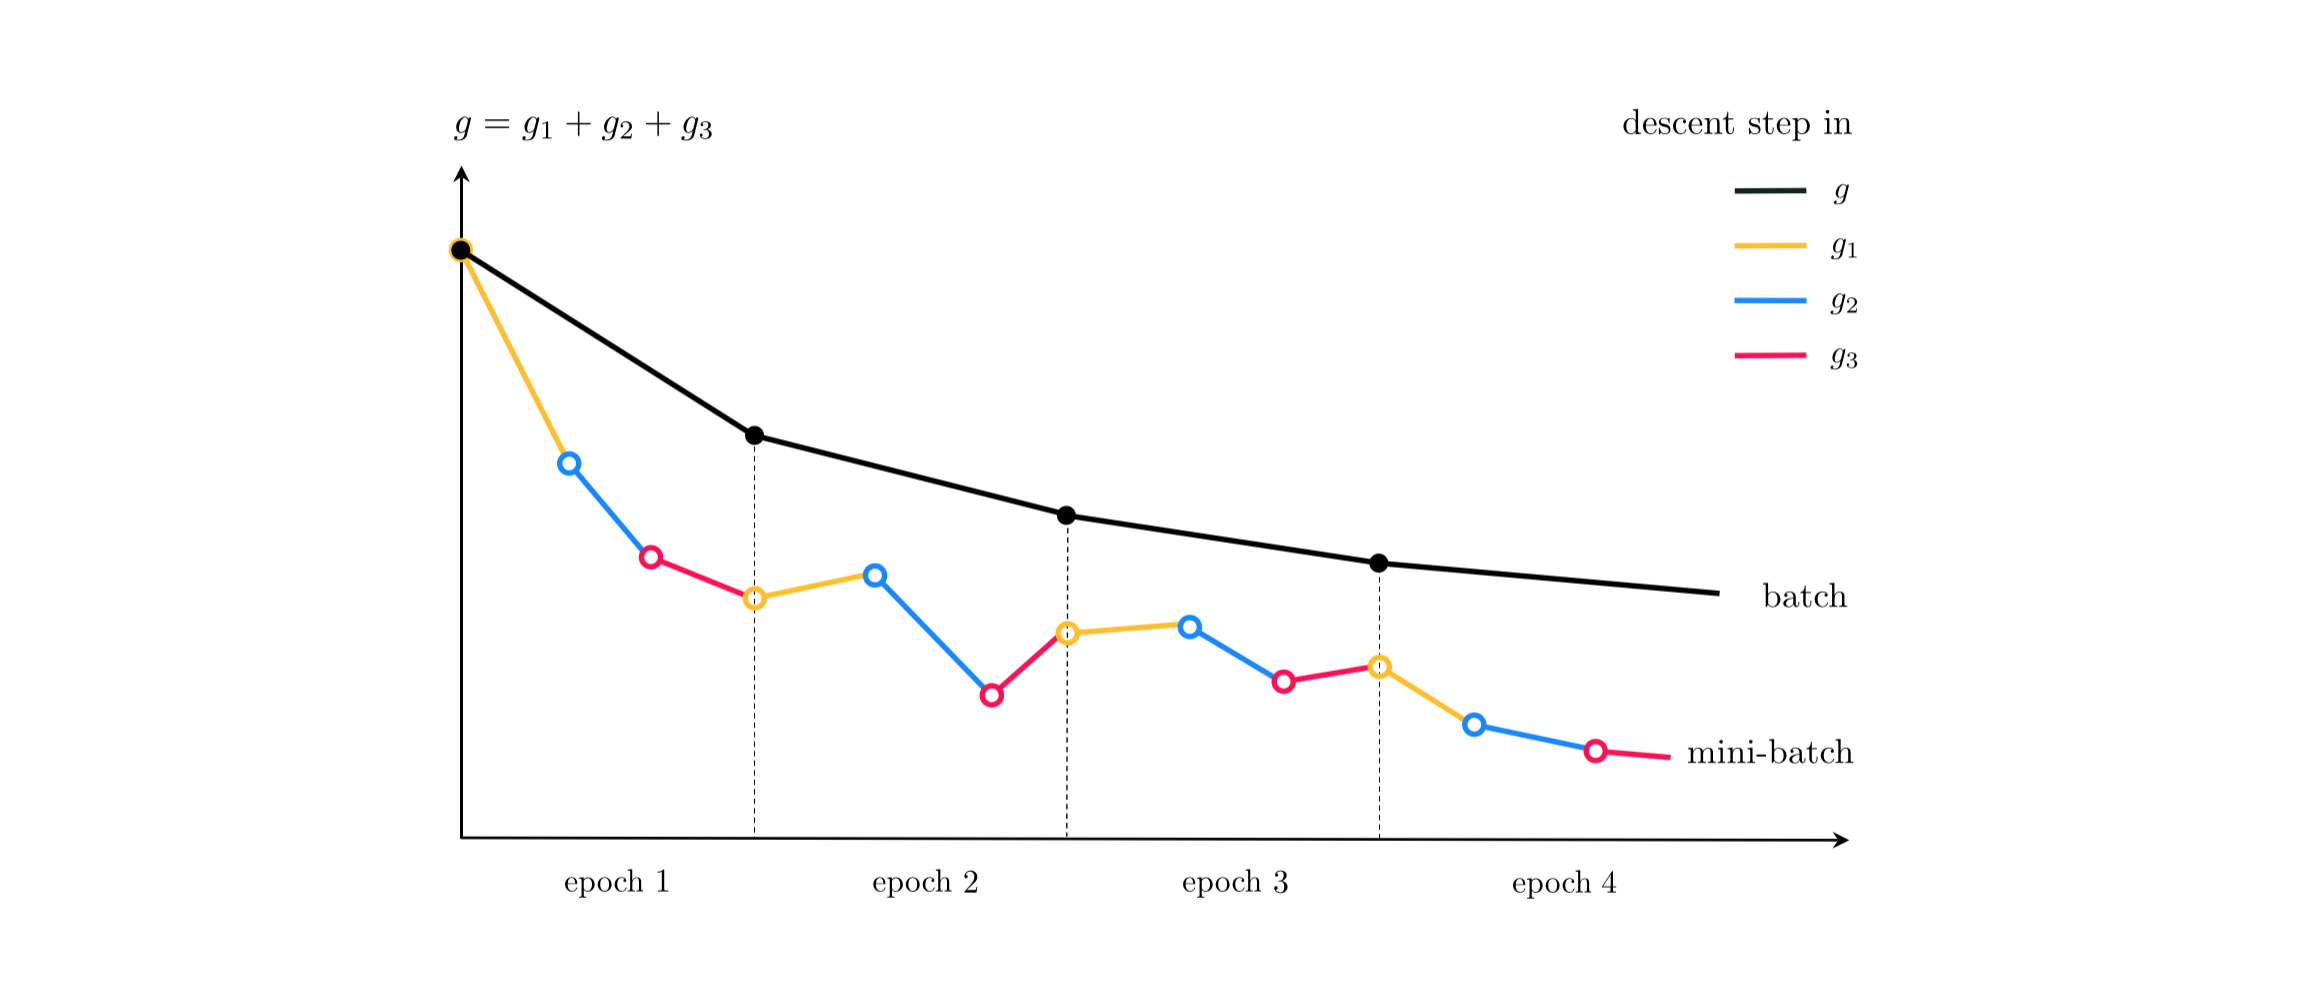

In [4]:
Image(image_path_2, width=1000)

#### <span style="color:#a50e3e;">Example 1. </span>  Minimizing a sum of quadratic functions via gradient based mini-batch optimization

In this example we will compare a full batch and two mini-batch runs (using batch-size $1$ and $10$ respectively) employing the standard gradient descent method.  The function $g$ we minimize in these various runs is as sum of $P = 100$ single input convex quadratic functions $g_p(w) = a^{\,}_p + b_pw + c_pw^2$.  In other words, our function $g$ takes the form

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p(w) = \sum_{p=1}^P\left( a^{\,}_p + b_pw + c_pw^2\right)
\end{equation}

All three runs use the same (random) initial point $w^0 = 0$ and a steplength / learning rate $\alpha = 10^{0}$ and we take $2$ epochs of each method.

Below we plot the cost function history plots associated with the full batch (shown in blue), mini-batch with batch-sizes equal to $10$ and $1$ (in magenta and black respectively).  In the left panel we show these three histories with respect to the batch-size = $1$ steps, that is we show the cost function value at every single step of the batch-size = $1$ method and plot the histories of our other mini-batch method every $10$ steps and full batch method every $100$ steps for visual comparison.  In the right panel we show all three histories only after each full epoch is complete.  From these plots can see clearly that both mini-batch approaches descended significantly faster than their full batch version.

In [5]:
class Quad_Sum:
    '''
    A small tool for creating a convex quadratic function that is a sum of convex quadratics, using iter
    to enable easy access to each of the quadratic functions / summands
    '''
    # function for creating constants of quadratic sum, here N is input dimension, P = number of summands
    def create_quadratic_constants(self,N,P): 
        # create list of random matrices, one for each term
        const_list = []
        for i in range(P):
            # generate constant
            a = np.random.randn(1,1)

            # generate b vector
            b = np.random.randn(N,1)

            # generate matrix
            C = np.random.randn(N, N)
            C = np.dot(C.T, C)
            const_list.append([a,b,C]) 

        self.const_list = const_list
        
    # final sum of quadratics
    def g(self,w,iter):
        cost = 0
        for i in iter:
            # get quadratic
            const = self.const_list[i]
            a = const[0]
            b = const[1]
            C = const[2]
            
            # add to term
            cost += (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]
        return cost/P
    
# Use the simple generator above to create an instance of the desired sum of convex quadratics
N = 1       # input dimension
P = 100     # number of convex quadratics / summands in function
demo = Quad_Sum()
demo.create_quadratic_constants(N,P)
g = demo.g    

In [6]:
# minibatch gradient descent
def gradient_descent(g, alpha, max_epochs, w, num_train, batch_size):        
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = value_and_grad(g_flat)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [g_flat(w,np.arange(num_train))]
   
    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))

    # over the line
    for k in range(max_epochs):                   
        # loop over each minibatch
        train_cost = 0
        for b in range(num_batches):
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))
            
            # plug in value into func and derivative
            cost_eval,grad_eval = grad(w,batch_inds)
            grad_eval.shape = np.shape(w)
    
            # take descent step with momentum
            w = w - alpha*grad_eval
        
            # update training and validation cost
            train_cost = g_flat(w,np.arange(num_train))

            # record weight update, train and val costs
            w_hist.append(unflatten(w))
            train_hist.append(train_cost)

    return w_hist,train_hist

In [7]:
### run full batch zero-order methods ###
num_train = P
batch_size = P
alpha_choice = 10**(0)
num_epochs = 2
w = np.random.randn(N)

# full batch run
batch_weight_hist,batch_cost_hist = gradient_descent(g, alpha_choice, num_epochs, w, num_train, batch_size)

# make stochastic run
batch_size = 1
minibatch_weight_hist, minibatch_cost_hist = gradient_descent(g, alpha_choice, num_epochs, w, num_train, batch_size)

# make mini-batch run of size 10
batch_size = 10
minibatch_weight_hist_2, minibatch_cost_hist_2 = gradient_descent(g, alpha_choice, num_epochs, w, num_train, batch_size)

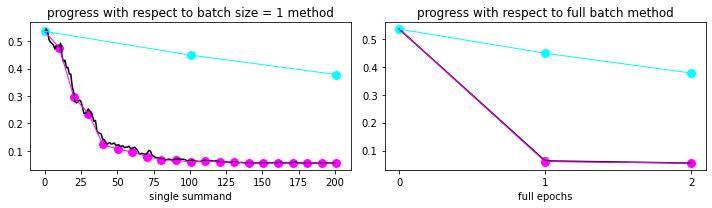

In [8]:
# plot runs
section_3_11_helpers.compare_runs(batch_cost_hist,minibatch_cost_hist,minibatch_cost_hist_2)

#### <span style="color:#a50e3e;">Example 2. </span>  Minimizing a sum of quadratic functions via zero order mini-batch optimization

In this example we will compare a full batch and two mini-batch runs (using batch-size $1$ and $10$ respectively) employing the zero order descent method *coordinate search* detailed in [Section 2.6](https://jermwatt.github.io/machine_learning_refined/notes/2_Zero_order_methods/2_6_Coordinate.html).  The function $g$ we minimize in these various runs is the same sum of random convex quadratics used in the previous Example.

Below we plot the cost function history plots associated with the full batch (shown in blue), mini-batch with batch-sizes equal to $10$ and $1$ (in magenta and black respectively).  In the left panel we show these three histories with respect to the batch-size = $1$ steps, that is we show the cost function value at every single step of the batch-size = $1$ method and plot the histories of our other mini-batch method every $10$ steps and full batch method every $100$ steps for visual comparison.  In the right panel we show all three histories only after each full epoch is complete.  In either case, we can see clearly that both mini-batch approaches descended significantly faster than their full batch version.

In [9]:
# zero order optimizer - designed to loop over mini-batches of functions
def coordinate_search(g,alpha_choice,max_its,w,num_train,batch_size):
    # construct set of all coordinate directions
    directions_plus = np.eye(np.size(w),np.size(w))
    directions_minus = - np.eye(np.size(w),np.size(w))
    directions = np.concatenate((directions_plus,directions_minus),axis=0)
        
    # run coordinate search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    
    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))

    # over the line
    for k in range(1,max_its + 1):                   
        # loop over each minibatch
        train_cost = 0
        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # range over mini-batches
        for b in range(num_batches):
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(g(w,np.arange(num_train)))
        
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))

            ### pick best descent direction
            # compute all new candidate points
            w_candidates = w + alpha*directions

            # evaluate all candidates
            evals = np.array([g(w_val,batch_inds) for w_val in w_candidates])

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if g(w_candidates[ind],batch_inds) < g(w,batch_inds):
                # pluck out best descent direction
                d = directions[ind,:]

                # take step
                w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w,np.arange(num_train)))
    return weight_history,cost_history

### run full batch zero-order methods ###
num_train = P
batch_size = P
alpha_choice = 10**(-2)
num_epochs = 2
batch_weight_hist,batch_cost_hist = coordinate_search(g,alpha_choice,num_epochs,w,num_train,batch_size)

# make stochastic run
batch_size = 1
minibatch_weight_hist, minibatch_cost_hist = coordinate_search(g,alpha_choice,num_epochs,w,num_train,batch_size)

# make mini-batch run of size 10
batch_size = 10
minibatch_weight_hist_2, minibatch_cost_hist_2 = coordinate_search(g,alpha_choice,num_epochs,w,num_train,batch_size)

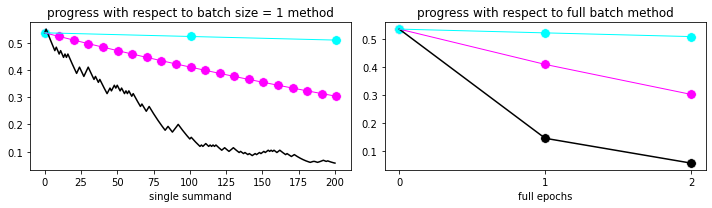

In [10]:
# plot runs 
section_3_11_helpers.compare_runs(batch_cost_hist,minibatch_cost_hist,minibatch_cost_hist_2)